<a href="https://colab.research.google.com/github/woodychang0611/EMNIST/blob/master/EMNIST_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment
If running on colab mount google drive, otherwise use 200g drive from NCCU GPU cloud

In [0]:
import sys
import os
if ('google.colab' in sys.modules):
  from google.colab import drive
  drive.mount('/content/gdrive')
  gdrive_root = 'gdrive/My Drive/Deep_Learning/'
  dataset_path = os.path.join(gdrive_root,'Dataset')
else:
  dataset_path = '200g/Dataset'
  pass

if not os.path.exists(dataset_path):
  raise Exception(f'dataset_path "{dataset_path}"" does not exist')


# Load Dataset

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim
import torch.autograd
import torchvision
import torchvision.transforms
import numpy as np
from torchsummary import summary
from matplotlib import pyplot as plt
import datetime

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (1.0,))])
use_cuda = None
if torch.cuda.is_available():
  print("CUDA available")
  use_cuda = True
else:
  print ("CUDA not available")
  use_cuda = False
if os.path.exists(dataset_path):
  train_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,train =True, split="byclass",download=True)
  test_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,split="byclass", train =False)
  print (f'Dataset loaded, {train_set.__len__():,} training set, {test_set.__len__():,} testing set')
else:
  print (f'dataset_path "{dataset_path}" not found')
  exit(0)

batch_size = 2048

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print ("Load training and testing data to memory")
preload_train_data = list(enumerate(train_loader))
preload_test_data = list(enumerate(test_loader))

CUDA available
Dataset loaded, 697,932 training set, 116,323 testing set
Load training and testing data to memory


# Common Functions

In [0]:
ceriation = nn.CrossEntropyLoss()
def apply_model(model,x,target):
    x, target = torch.autograd.Variable(x), torch.autograd.Variable(target)
    out = model(x)
    loss = torch.nn.CrossEntropyLoss()(out, target)
    return out,loss
def plot_graph(name,train_loss,test_loss):
  fig, ax = plt.subplots()
  ax.plot(train_loss,label='train loss')
  ax.plot(test_loss,label='test loss')  
  ax.set(xlabel='epoch', ylabel='Loss',title=name)
  plt.legend()
  plt.show()


# Define DNN

In [0]:
#DNN
class DNN(nn.Module):
    def __init__(self,dropouts=(0,),layer_widths=(512,),lr=0.1,epoch=30):
        super(DNN, self).__init__()
        if (len(dropouts) != len(layer_widths) or len(dropouts)<=0 or len(layer_widths)<=0):
          raise Exception ("dropouts and layer_widths must have same width and greater than 0")
        self.dropouts=dropouts
        self.layer_widths = layer_widths
        self.lr =lr
        self.epoch= epoch
        input_width = 28*28
        self.fc = nn.ModuleList()
        for width in self.layer_widths:
          self.fc.append(nn.Linear(input_width, width))
          input_width = width
        self.final = nn.Linear(layer_widths[-1], 62)

    def forward(self, x):
        x = x.view(-1, 28*28)
        for dropout, fc in zip(self.dropouts,self.fc):
          x = F.dropout(x,dropout)
          x = fc(x)
          x = F.relu(x)
        x = self.final(x)
        return x
    @property
    def name(self):
        return f"DNN, Width:{self.layer_widths}, Dropout: {self.dropouts}, learning rate: {self.lr}"

2020-04-04 14:59:10.094971
model:DNN, Width:(500, 256), Dropout: (0, 0), learning rate: 0.01
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
            Linear-2                  [-1, 256]         128,256
            Linear-3                   [-1, 62]          15,934
Total params: 536,690
Trainable params: 536,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.05
Estimated Total Size (MB): 2.06
----------------------------------------------------------------
0:0.78028,1:0.81239,2:0.82516,3:0.83267,4:0.83776,5:0.84153,6:0.84381,7:0.84579,8:0.84759,9:0.84872,10:0.85015,11:0.85064,12:0.85149,13:0.85215,14:0.85272,15:0.85294,16:0.85313,17:0.85304,18:0.85277,19:0.85269,20:0.85260,21:0.85294,22:0.85282,23:0.85245,24:0.85268,25:0

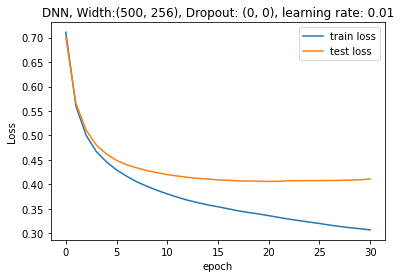

2020-04-04 15:01:38.383134
model:DNN, Width:(500, 256), Dropout: (0, 0), learning rate: 0.003
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
            Linear-2                  [-1, 256]         128,256
            Linear-3                   [-1, 62]          15,934
Total params: 536,690
Trainable params: 536,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.05
Estimated Total Size (MB): 2.06
----------------------------------------------------------------
0:0.69007,1:0.74871,2:0.78007,3:0.79731,4:0.80757,5:0.81548,6:0.82110,7:0.82515,8:0.82857,9:0.83144,10:0.83398,11:0.83597,12:0.83822,13:0.83970,14:0.84115,15:0.84230,16:0.84299,17:0.84412,18:0.84507,19:0.84582,20:0.84618,21:0.84690,22:0.84747,23:0.84815,24:0.84852,25:

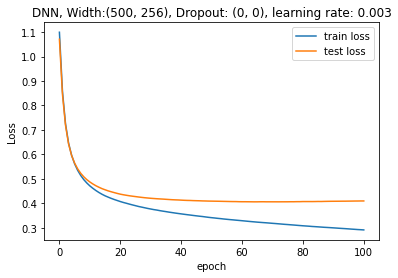

2020-04-04 15:09:39.229501
model:DNN, Width:(700, 256), Dropout: (0, 0), learning rate: 0.003
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 256]         179,456
            Linear-3                   [-1, 62]          15,934
Total params: 744,890
Trainable params: 744,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.84
Estimated Total Size (MB): 2.85
----------------------------------------------------------------
0:0.69379,1:0.75008,2:0.77863,3:0.79627,4:0.80770,5:0.81526,6:0.82098,7:0.82516,8:0.82861,9:0.83151,10:0.83417,11:0.83611,12:0.83811,13:0.83970,14:0.84080,15:0.84209,16:0.84326,17:0.84429,18:0.84496,19:0.84571,20:0.84660,21:0.84706,22:0.84775,23:0.84812,24:0.84877,25:

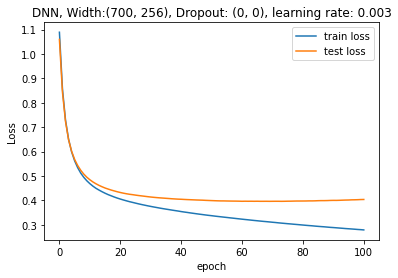

2020-04-04 15:17:41.186538
model:DNN, Width:(700, 500, 256), Dropout: (0, 0, 0), learning rate: 0.003
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 500]         350,500
            Linear-3                  [-1, 256]         128,256
            Linear-4                   [-1, 62]          15,934
Total params: 1,044,190
Trainable params: 1,044,190
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.98
Estimated Total Size (MB): 4.00
----------------------------------------------------------------
0:0.68776,1:0.76036,2:0.79180,3:0.80780,4:0.81871,5:0.82532,6:0.82996,7:0.83356,8:0.83609,9:0.83844,10:0.84017,11:0.84152,12:0.84320,13:0.84424,14:0.84532,15:0.84625,16:0.84718,17:0.84805,18:0

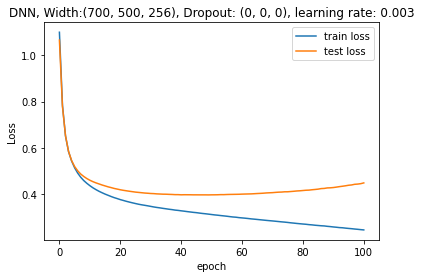

2020-04-04 15:27:08.706605
model:DNN, Width:(700, 500, 256), Dropout: (0.3, 0.3, 0), learning rate: 0.003
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 500]         350,500
            Linear-3                  [-1, 256]         128,256
            Linear-4                   [-1, 62]          15,934
Total params: 1,044,190
Trainable params: 1,044,190
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.98
Estimated Total Size (MB): 4.00
----------------------------------------------------------------
0:0.65081,1:0.71823,2:0.75006,3:0.76767,4:0.77784,5:0.78739,6:0.79308,7:0.79855,8:0.80252,9:0.80628,10:0.80970,11:0.81281,12:0.81386,13:0.81561,14:0.81858,15:0.81964,16:0.82091,17:0.82257,

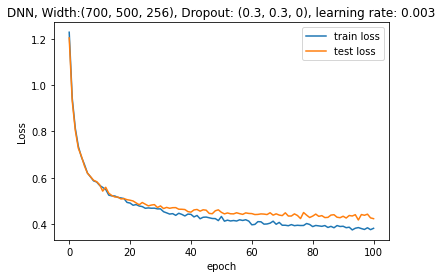

In [0]:
models = (
    DNN(layer_widths = (500,256,), dropouts = (0,0,),lr=0.01,epoch=30),    
    DNN(layer_widths = (500,256,), dropouts = (0,0,),lr=0.003,epoch=100),    
    DNN(layer_widths = (700,256,), dropouts = (0,0,),lr=0.003,epoch=100), 
    DNN(layer_widths = (700,500,256,), dropouts = (0,0,0,),lr=0.003,epoch=100),
    #DNN(layer_widths = (700,500,256,), dropouts = (0.3,0.3,0,),lr=0.003,epoch=100)
    )
sample_limit = 100000000
for model in models:
  name = model.name
  print(datetime.datetime.now())
  optimizer = torch.optim.SGD(model.parameters(), lr=model.lr, momentum=0.9)
  parameter_len = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'model:{name}')
  train_loss=[]
  test_loss=[]
  if use_cuda:
    model.cuda()
  summary(model,(1,28,28))
  best_acc = 0
  best_epoch = 0
  for epoch in range(model.epoch+1):
    # training
    ave_loss = 0
    for batch_idx, (x, target) in preload_train_data:
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        out,loss = apply_model (model,x,target)
        ave_loss = ave_loss * 0.9 + loss.data* 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) == len(train_loader) or batch_idx >sample_limit:
            #print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, train loss: {ave_loss:.6f}')
            break
    train_loss.append(ave_loss)
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in preload_test_data:
        if use_cuda:
          x, target = x.cuda(), target.cuda()      
        out,loss = apply_model (model,x,target)        
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        if (batch_idx) == len(test_loader)-1 or batch_idx >sample_limit:
            #print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, test loss: {ave_loss:.6f}, acc: {correct_cnt * 1.0 / total_cnt:.3f}')
            break
    acc = correct_cnt * 1.0 / total_cnt
    print(f'{epoch}:{acc:.5f}', end=',')
    test_loss.append(ave_loss)
    if (acc > best_acc):
      best_acc = acc
      best_epoch = epoch
  print (f"\nBest Accuracy:{best_acc} at epoch {best_epoch}")  
  plot_graph(name,train_loss,test_loss)    